<a href="https://colab.research.google.com/github/Syed-Osama-Hussain/Imagined-Speech-Prediction-from-EEG/blob/master/Long_words_PCA_TSNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import scipy.io
import scipy.interpolate
import os
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, LSTM, Dropout, Input, Reshape, GRU
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers.merge import concatenate
from keras.utils import plot_model
from keras.models import Model, load_model
import keras.backend as K
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
def covariance(matrix):
  # matrix = matrix[[2,3,5,36,37,38], :]
  matrix = np.delete(matrix,(0,9,32,63), 0)
  res_mat = (np.cov(matrix,bias=True))
  return res_mat

In [4]:
def loadMatrices(dir):
  matrices_c1 = []
  matrices_c2 = []
  for root,sub,files in os.walk(dir):
    for f in sorted(files):
      mat_file  =  scipy.io.loadmat(os.path.join(root, f))
      end_trial = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_end_trial']
      last_beep = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
      matrices_c1.extend([covariance(matrix) for matrix in last_beep[0]])
      matrices_c2.extend([covariance(matrix) for matrix in last_beep[1]])
  return np.concatenate((np.array(matrices_c1),np.array(matrices_c2)),axis=0)


In [5]:
data = loadMatrices("drive/My Drive/dataset/Long_words/")

In [6]:
print(data.shape)

(1000, 60, 60)


In [7]:
labels = np.concatenate((np.zeros(500),np.ones(500)),axis=0)
print(labels.shape)

(1000,)


In [8]:
from keras.utils.np_utils import to_categorical
labels = to_categorical(labels, num_classes=2)
print(labels.shape,labels)

(1000, 2) [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [10]:
#CNN
visible = Input(shape=(60,60))
cov1 = Conv1D(filters=60, kernel_size=2, activation="relu")(visible)
dropout1 = Dropout(0.25)(cov1)
cov2 = Conv1D(filters=60, kernel_size=4, activation="relu")(dropout1)
dropout2 = Dropout(0.5)(cov2)
newShape = Reshape((56,60), name='newReshape')(dropout2)
f1 = Flatten()(newShape)
d1 = Dense(120, activation='relu')(f1)
d2 = Dense(120, activation='relu')(d1)
output = Dense(2, activation='softmax')(d2)
model = Model(inputs=visible, outputs=output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 60, 60)]          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 59, 60)            7260      
_________________________________________________________________
dropout_2 (Dropout)          (None, 59, 60)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 56, 60)            14460     
_________________________________________________________________
dropout_3 (Dropout)          (None, 56, 60)            0         
_________________________________________________________________
newReshape (Reshape)         (None, 56, 60)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3360)              0   

In [11]:
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
data, labels = shuffle(data, labels)

In [13]:
divide_percent = int(len(data)*0.2)
y_test = labels[0:divide_percent]
x_test = data[0:divide_percent]
train_data = data[divide_percent:len(data)]
train_labels = labels[divide_percent:len(labels)]

In [14]:
print(y_test.shape,x_test.shape,train_data.shape,train_labels.shape)

(200, 2) (200, 60, 60) (800, 60, 60) (800, 2)


In [15]:
train_data, train_labels = shuffle(train_data, train_labels)
model.fit(train_data,train_labels,validation_data=(x_test,y_test),batch_size=64,epochs=100,verbose=1)

Epoch 1/100
13/13 [==============================] - 2s 69ms/step - loss: 11.2984 - accuracy: 0.4904 - val_loss: 1.2048 - val_accuracy: 0.5700
Epoch 2/100
13/13 [==============================] - 0s 30ms/step - loss: 8.8053 - accuracy: 0.5028 - val_loss: 1.3089 - val_accuracy: 0.5300
Epoch 3/100
13/13 [==============================] - 0s 30ms/step - loss: 9.1949 - accuracy: 0.4828 - val_loss: 1.1706 - val_accuracy: 0.5500
Epoch 4/100
13/13 [==============================] - 0s 31ms/step - loss: 8.3883 - accuracy: 0.4692 - val_loss: 1.5608 - val_accuracy: 0.5800
Epoch 5/100
13/13 [==============================] - 0s 31ms/step - loss: 8.2764 - accuracy: 0.4936 - val_loss: 1.6491 - val_accuracy: 0.5650
Epoch 6/100
13/13 [==============================] - 0s 32ms/step - loss: 8.2542 - accuracy: 0.4845 - val_loss: 1.2674 - val_accuracy: 0.5650
Epoch 7/100
13/13 [==============================] - 0s 31ms/step - loss: 7.4156 - accuracy: 0.4952 - val_loss: 1.1290 - val_accuracy: 0.5400
Epoch

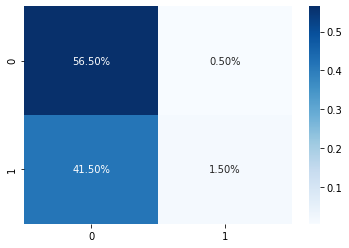

In [16]:
predictions = model.predict(x_test)
np.round(predictions)
rounded_labels = np.argmax(y_test, axis=1)
rounded_predictions = np.argmax(predictions, axis=1)
cf = confusion_matrix(rounded_labels,rounded_predictions)  # doctest: +SKIP
sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')

In [17]:
# RNN
gru1 = GRU(60,activation="relu",return_sequences=True)(model.input)
dropout3 = Dropout(0.25)(gru1)
gru2 = GRU(60,activation="relu")(dropout3)
dropout4 = Dropout(0.5)(gru2)
d3 = Dense(60, activation='relu')(dropout4)
d4 = Dense(60, activation='relu')(d3)
output = Dense(2, activation='softmax')(d4)
model2 = Model(inputs=model.input, outputs=output)
model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 60, 60)]          0         
_________________________________________________________________
gru (GRU)                    (None, 60, 60)            21960     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 60)                21960     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 60)                3660      
_________________________________________________________________
dense_7 (Dense)              (None, 60)                3660

In [18]:
optimizer = Adam(learning_rate=0.00001)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
train_data, train_labels = shuffle(train_data, train_labels)
model2.fit(train_data,train_labels,validation_data=(x_test,y_test),batch_size=64,epochs=100,verbose=1)

Epoch 1/100
13/13 [==============================] - 4s 121ms/step - loss: 2.0812 - accuracy: 0.4856 - val_loss: 1.7348 - val_accuracy: 0.4350
Epoch 2/100
13/13 [==============================] - 1s 88ms/step - loss: 2.0707 - accuracy: 0.5079 - val_loss: 1.6658 - val_accuracy: 0.4350
Epoch 3/100
13/13 [==============================] - 1s 87ms/step - loss: 5.3462 - accuracy: 0.4877 - val_loss: 1.6008 - val_accuracy: 0.4400
Epoch 4/100
13/13 [==============================] - 1s 87ms/step - loss: 2.8480 - accuracy: 0.5081 - val_loss: 1.5550 - val_accuracy: 0.4400
Epoch 5/100
13/13 [==============================] - 1s 85ms/step - loss: 12.3183 - accuracy: 0.4824 - val_loss: 1.5038 - val_accuracy: 0.4400
Epoch 6/100
13/13 [==============================] - 1s 89ms/step - loss: 3.7797 - accuracy: 0.4932 - val_loss: 1.4771 - val_accuracy: 0.4350
Epoch 7/100
13/13 [==============================] - 1s 83ms/step - loss: 3.6651 - accuracy: 0.4998 - val_loss: 1.4598 - val_accuracy: 0.4350
Epoc

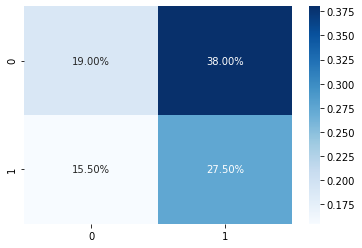

In [19]:
predictionsRNN = model2.predict(x_test)
np.round(predictionsRNN)
rounded_labels = np.argmax(y_test, axis=1)
rounded_predictionsRNN = np.argmax(predictionsRNN, axis=1)
cfRNN = confusion_matrix(rounded_labels,rounded_predictionsRNN)  # doctest: +SKIP
sns.heatmap(cfRNN/np.sum(cfRNN), annot=True, fmt='.2%', cmap='Blues')

In [20]:
for layer in model.layers:
  layer.trainable = False

for layer in model2.layers:
  layer.trainable = False

In [21]:
def createFeatureModel(modelCNN, modelRNN):
  outputs = [modelCNN.layers[8].output,modelRNN.layers[6].output]
  merge = concatenate(outputs)
  featureModel = Model(inputs=modelCNN.input, outputs=merge)
  return featureModel

In [22]:
def extractFeatures(model, data):
  features = model.predict(data,verbose=0)
  return features

In [23]:
featureModel = createFeatureModel(model,model2)
train_features = extractFeatures(featureModel, train_data)
test_features = extractFeatures(featureModel, x_test)
print(train_features.shape, test_features.shape)

(800, 180) (200, 180)


In [24]:
from sklearn.preprocessing import StandardScaler
standardData = StandardScaler().fit_transform(train_features)
print(standardData.shape,np.mean(standardData),np.std(standardData))

(800, 180) -3.5762787e-10 0.9006171


In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(standardData)

In [31]:
print(pca.explained_variance_ratio_)

[0.6447153  0.08226921]


In [33]:
print(principal_components.shape)

(800, 2)


In [34]:
c1 = []
c2 = []
for i in range(len(train_labels)):
    output_class = np.argmax(train_labels[i])
    if(output_class == 0):
        c1.append(principal_components[i])
    else:
        c2.append(principal_components[i])
print(len(c1),len(c2))

386 414


In [36]:
c2 = c2[:386]

In [37]:
print(len(c1),len(c2))

386 386


<Figure size 432x288 with 0 Axes>

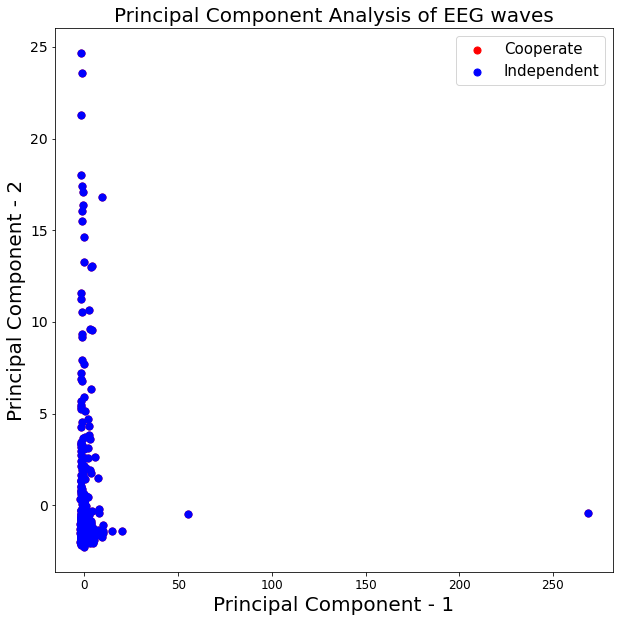

In [40]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of EEG waves",fontsize=20)
targets = ['Cooperate', 'Independent']
colors = ['r', 'b']
for target, color in zip(targets,colors):
    # indicesToKeep = breast_dataset['label'] == target
    plt.scatter(c1, c2, c = color, s = 50)

plt.legend(targets,prop={'size': 15})

In [27]:
color_intermediates = []
for i in range(len(train_labels)):
    output_class = np.argmax(train_labels[i])
    if(output_class == 0):
        color_intermediates.append("#0000ff")
    else:
        color_intermediates.append("#ff0000")

In [28]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
intermediates_tsne = tsne.fit_transform(train_features)

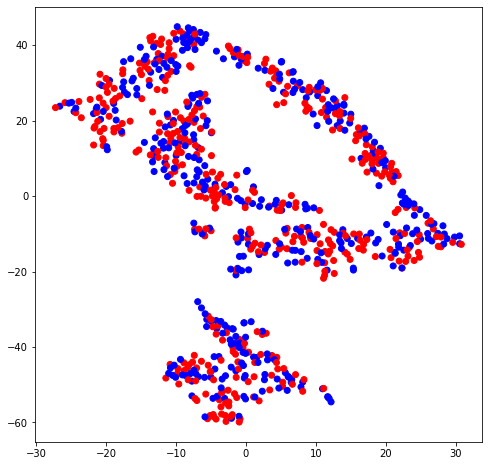

In [29]:
plt.figure(figsize=(8, 8))
plt.scatter(x = intermediates_tsne[:,0], y=intermediates_tsne[:,1], color=color_intermediates)
plt.show()